In [98]:
# Libraries

from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [99]:
# Create list of all targets (minus background noise)
dataset_path = '../data_speech_commands_v0.02'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)
target_number = len(all_targets)
print(f'Number of labels: {target_number}')  

['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'forward', 'off', 'four']
Number of labels: 35


In [100]:
# Settings
feature_sets_path = '.'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'all_targets_model.h5'
wake_word = 'stop'

In [101]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [102]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = np.zeros((len(feature_sets['y_train']), len(all_targets)))
y_train[:,0] = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = np.zeros((len(feature_sets['y_val']), len(all_targets)))
y_val[:,0] = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = np.zeros((len(feature_sets['y_test']), len(all_targets)))
y_test[:,0] = feature_sets['y_test']

In [103]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(84665, 16, 16)
(10582, 16, 16)
(10582, 16, 16)
(84665, 35)
(10582, 35)
(10582, 35)


In [104]:
# Peek at labels
print(y_val)


[[29.  0.  0. ...  0.  0.  0.]
 [31.  0.  0. ...  0.  0.  0.]
 [18.  0.  0. ...  0.  0.  0.]
 ...
 [33.  0.  0. ...  0.  0.  0.]
 [29.  0.  0. ...  0.  0.  0.]
 [33.  0.  0. ...  0.  0.  0.]]


In [105]:
# Convert ground truth arrays to one wake word
for word in all_targets:
    wake_word_index = all_targets.index(word)
    print(f"{wake_word_index} = {word}")
    for i in range(len(y_train[:,0])):
        if y_train[i,0] == wake_word_index :
            y_train[i,:] = np.zeros((1, len(all_targets)))
            y_train[i,wake_word_index] = 1.0

    for i in range(len(y_val[:,0])):
        if y_val[i,0] == wake_word_index :
            y_val[i,:] = np.zeros((1, len(all_targets)))
            y_val[i,wake_word_index] = 1.0

    for i in range(len(y_test[:,0])):
        if y_test[i,0] == wake_word_index :
            y_test[i,:] = np.zeros((1, len(all_targets)))
            y_test[i,wake_word_index] = 1.0

0 = right
1 = eight
2 = cat
3 = tree
4 = backward
5 = learn
6 = bed
7 = happy
8 = go
9 = dog
10 = no
11 = wow
12 = follow
13 = nine
14 = left
15 = stop
16 = three
17 = sheila
18 = one
19 = bird
20 = zero
21 = seven
22 = up
23 = visual
24 = marvin
25 = two
26 = house
27 = down
28 = six
29 = yes
30 = on
31 = five
32 = forward
33 = off
34 = four


In [106]:
# Peek at labels after conversion
print(y_val)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [107]:
# What percentage of 'stop' appear in validation labels
print(f"Percentage of Stop : {sum(y_val[:,15]) / len(y_val[:,15])}")
print(f"Percentage of Eight : {sum(y_val[:,1]) / len(y_val[:,1])}")

Percentage of Stop : 0.038934038934038934
Percentage of Eight : 0.06605556605556606


In [108]:
# View the dimensions of our input data
print(x_train.shape)

(84665, 16, 16)


In [109]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(84665, 16, 16, 1)
(10582, 16, 16, 1)
(10582, 16, 16, 1)


In [110]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [111]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(16, #32
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(16, (2, 2), activation='relu')) #32
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu')) #64
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu')) #64
model.add(layers.Dropout(0.5))
model.add(layers.Dense(target_number, activation='sigmoid'))

In [112]:
# Display model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 15, 15, 16)        80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 6, 6, 16)          1040      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 2, 2, 32)          2080      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 1, 1, 32)        

In [113]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [114]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
847/847 [==============================] - 6s 6ms/step - loss: 0.1964 - acc: 0.0611 - val_loss: 0.1181 - val_acc: 0.1084
Epoch 2/30
847/847 [==============================] - 4s 5ms/step - loss: 0.1250 - acc: 0.1314 - val_loss: 0.1061 - val_acc: 0.1930
Epoch 3/30
847/847 [==============================] - 4s 5ms/step - loss: 0.1150 - acc: 0.1794 - val_loss: 0.1005 - val_acc: 0.2402
Epoch 4/30
847/847 [==============================] - 5s 5ms/step - loss: 0.1090 - acc: 0.2137 - val_loss: 0.0944 - val_acc: 0.3273
Epoch 5/30
847/847 [==============================] - 4s 5ms/step - loss: 0.1039 - acc: 0.2509 - val_loss: 0.0891 - val_acc: 0.3725
Epoch 6/30
847/847 [==============================] - 4s 5ms/step - loss: 0.0988 - acc: 0.2838 - val_loss: 0.0855 - val_acc: 0.4100
Epoch 7/30
847/847 [==============================] - 5s 5ms/step - loss: 0.0951 - acc: 0.3065 - val_loss: 0.0812 - val_acc: 0.4473
Epoch 8/30
847/847 [==============================] - 5s 5ms/step - loss: 0.

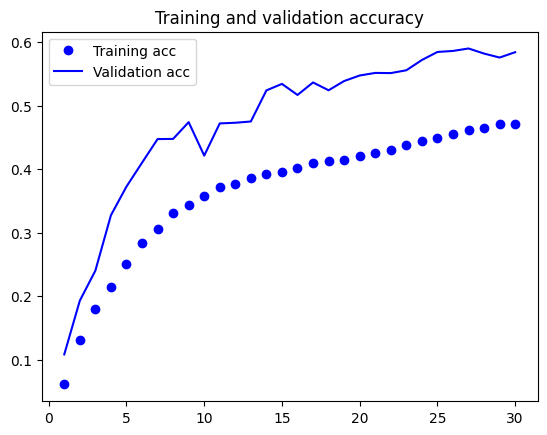

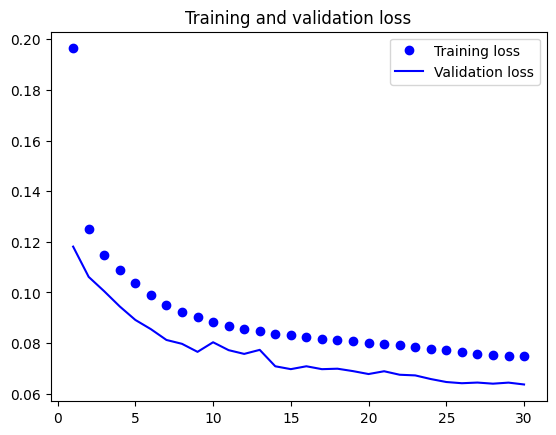

In [115]:
# Plot results


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [116]:
# Save the model as a file
models.save_model(model, model_filename)

In [117]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y[15] == 1:
        print(idx)

72
75
108
133
170
172
220
222
230
256
260
322
377
390
430
473
492
508
542
546
563
583
586
615
666
679
694
791
818
849
956
970
992
1015
1023
1024
1056
1067
1085
1096
1098
1105
1117
1121
1163
1186
1263
1313
1386
1458
1460
1526
1571
1586
1598
1606
1628
1657
1709
1725
1754
1761
1798
1839
1852
1856
1860
1866
1892
1896
1919
1938
1962
1967
2015
2027
2049
2054
2067
2080
2083
2086
2098
2105
2121
2181
2205
2212
2243
2250
2255
2276
2278
2293
2320
2340
2352
2354
2357
2400
2471
2644
2653
2705
2721
2735
2740
2831
2833
2837
2857
2867
2868
2895
2928
2935
2938
2951
2952
2965
3014
3072
3093
3111
3228
3230
3295
3299
3317
3362
3380
3385
3487
3568
3574
3580
3600
3681
3695
3732
3746
3757
3761
3762
3796
3808
3827
3831
3973
3996
3999
4014
4042
4049
4088
4119
4132
4138
4203
4213
4265
4273
4292
4331
4332
4367
4412
4414
4452
4494
4510
4535
4576
4625
4634
4637
4656
4690
4696
4735
4763
4791
4799
4800
4802
4818
4819
4827
4840
4945
4947
5026
5041
5066
5073
5079
5115
5134
5215
5217
5239
5305
5353
5366
5385
5430
5442


In [118]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 79ms/step
Answer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  Prediction: [[1.61441349e-07 9.13392723e-05 2.32873033e-04 4.49251593e-06
  2.81903963e-03 8.77103448e-05 1.07206006e-05 3.09060299e-04
  4.74131433e-03 2.60939877e-02 4.35206195e-04 1.74144609e-03
  8.66496116e-02 7.97212706e-05 3.35006880e-05 2.00214311e-02
  2.21476739e-06 1.49600032e-06 3.29514092e-04 1.15018454e-04
  3.58512523e-07 6.34654541e-04 6.46348298e-02 8.35801075e-06
  8.84075067e-04 1.84680248e-05 2.31337361e-02 8.80089996e-04
  2.76262426e-07 3.36427632e-07 1.62969306e-01 1.27777364e-02
  2.63075531e-02 9.88840014e-02 1.58302151e-02]]
1/1 [==============================] - 0s 22ms/step
Answer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  Prediction: [[3.1312920e-06 2.7168965e-02 1.6635864e-05 1.0909428e-03 1.8086363e-02
  4.6240121e-02 3.929

In [119]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

331/331 [==============================] - 1s 2ms/step - loss: 0.0631 - acc: 0.5859


[0.06308819353580475, 0.585900604724884]